# Predicción de Quality Leads (QL)
## Problema
Cuando una persona registra su tienda en la plataforma tiene un periodo de prueba de 30 días en los cuales puede decidir si continuar o no utilizando el servicio. Durante el período de prueba la tienda es un trial. Una vez transcurridos los 30 días la tienda puede decidir continuar utilizando el servicio pero de forma paga, en ese caso se convierte en un payment.
En Tienda nuestro objetivo es brindarle a nuestros clientes la mejor calidad de atención. Pero dado el volumen de suscriptores diarios que viene registrando la plataforma de un tiempo a esta parte es muy dificultoso atenderlos a todos a la vez.
Para dar respuesta a este problema es necesario encontrar una forma de priorizar a nuestros clientes. Como Tienda no solo provee un servicio sino que también necesita ganar dinero para poder continuar operando, es necesario dar prioridad a aquellos potenciales clientes (trials) que van a continuar utilizando el servicio y pagando por el mismo (payment).
## Tareas a Desarrollar:
1. Desarrollar uno o varios modelos que permitan predecir con mayor exactitud los trials que se van a convertir en payments
   * Explicar brevemente cual fue el criterio por el cual se eligió el modelo y porqué se seleccionó dicha métrica
2. Obtener al menos 3 (insights) de lo obtenido por el modelo que puedan ser de utilidad para el negocio.


*Aclaración: El objetivo del ejercicio no se centra exclusivamente en la obtención del mejor modelo posible sino en el desarrollo por el cual se arribó al mismo y las conclusiones posteriores.*


## Diccionario Dataset
* Id: Identificador númerico de los trials
* Country: país de origen del trial
* Creation_platform: plataforma por la cual se creó la tienda
* Admin_visits: cantidad de visitas que registró el administrador
* Intercom_conversations: cantidad de conversaciones que registró la tienda
con el equipo de soporte
* Source_pulido: origen de la tienda por campaña de marketing
* Creation_weekday: día de la semana en que se creó la tienda
* Creation_hour: hora del día en la que se creó la tienda
* Products_with_description: cantidad de productos que poseen descripción
* total_products_with_images: cantidad de productos que poseen imagen
* total_product_categories: cantidad de categorías de productos creadas
* total_events_on_Android: registro de la cantidad de eventos que tuvo el trial
por un dispositivo con sistema operativo Android
* total_events_on_Web: registro de la cantidad de eventos que tuvo el trial por
una computadora
* total_events_on_iOS: registro de la cantidad de eventos que tuvo el trial por un
dispositivo con sistema operativo iOS
* Target:
   * El trial luego del periodo de prueba se convirtió en payment
   * 0: El trial no se convirtió a payment

___
## 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
from utils import plot_utils, transform_data

transformer = transform_data.Transformer('nb')

___
## 1. Initial exploratory analysis

In [4]:
# Read dataset
df = pd.read_csv('./data.csv', sep=';')

In [5]:
# Reorder columns by name
df = df.reindex(sorted(df.columns), axis=1)

In [6]:
# Show dataset head
df.head()

,Unnamed: 0,admin_visits,country,creation_hour,creation_platform,creation_weekday,id,intercom_conversations,products_with_description,source_pulido,target,total_events_on_Android,total_events_on_Web,total_events_on_iOS,total_product_categories,total_products_with_images
0,0,1.0,BR,3,mobile_app,6,589015,0.0,2.0,Other,0,215.0,6.0,0.0,0.0,1
1,1,2.0,BR,3,mobile_web,6,589016,0.0,1.0,Google CPC no Brand,0,0.0,44.0,0.0,0.0,1
2,2,1.0,BR,3,mobile_web,6,589017,0.0,0.0,Google CPC no Brand,0,0.0,16.0,0.0,0.0,0
3,3,1.0,BR,3,mobile_web,6,589018,0.0,0.0,Google CPC no Brand,0,0.0,15.0,0.0,0.0,0
4,4,1.0,BR,3,mobile_web,6,589019,0.0,0.0,Google CPC no Brand,0,0.0,24.0,0.0,0.0,0


In [7]:
df.columns

Index(['Unnamed: 0', 'admin_visits', 'country', 'creation_hour',
       'creation_platform', 'creation_weekday', 'id', 'intercom_conversations',
       'products_with_description', 'source_pulido', 'target',
       'total_events_on_Android', 'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images'],
      dtype='object')

In [8]:
# Delete unnecessary column
df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [9]:
# Check
df.columns

Index(['admin_visits', 'country', 'creation_hour', 'creation_platform',
       'creation_weekday', 'id', 'intercom_conversations',
       'products_with_description', 'source_pulido', 'target',
       'total_events_on_Android', 'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images'],
      dtype='object')

In [10]:
# Show main statistics
print("Original quantity of examples:", df.shape[0])
print("Original quantity of columns", df.shape[1])
print("Dataset main statistics:")
df.describe()

Original quantity of examples: 585340
Original quantity of columns 15
Dataset main statistics:


,admin_visits,creation_hour,creation_weekday,id,intercom_conversations,products_with_description,target,total_events_on_Android,total_events_on_Web,total_events_on_iOS,total_product_categories,total_products_with_images
count,585340.000000,585340.000000,585340.000000,5.853400e+05,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000
mean,1.091154,13.565886,2.725496,8.849227e+05,0.005793,5.232655,0.080071,7.105310,68.441636,0.895406,1.289987,5.198054
std,0.543782,7.157861,1.937653,1.711352e+05,0.118485,104.301081,0.271404,36.444225,124.612021,12.274338,9.712947,97.490506
min,0.000000,0.000000,0.000000,5.890150e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,10.000000,1.000000,7.365218e+05,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000
50%,1.000000,15.000000,3.000000,8.847855e+05,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000
75%,1.000000,19.000000,4.000000,1.032991e+06,0.000000,1.000000,0.000000,0.000000,70.000000,0.000000,0.000000,1.000000
max,22.000000,23.000000,6.000000,1.181809e+06,27.000000,28530.000000,1.000000,1706.000000,14596.000000,2527.000000,3059.000000,28530.000000


In [11]:
# dataset bigpicture
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585340 entries, 0 to 585339
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   admin_visits                585340 non-null  float64
 1   country                     585340 non-null  object 
 2   creation_hour               585340 non-null  int64  
 3   creation_platform           585340 non-null  object 
 4   creation_weekday            585340 non-null  int64  
 5   id                          585340 non-null  int64  
 6   intercom_conversations      585340 non-null  float64
 7   products_with_description   585340 non-null  float64
 8   source_pulido               585340 non-null  object 
 9   target                      585340 non-null  int64  
 10  total_events_on_Android     585340 non-null  float64
 11  total_events_on_Web         585340 non-null  float64
 12  total_events_on_iOS         585340 non-null  float64
 13  total_product_

### Separation of features and labels

In [12]:
# Distinguishing between features and labels
label = 'target'
Y = df[label].copy()
X = df.drop([label, label], axis=1)
print("df shape:", df.shape)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

df shape: (585340, 15)
X shape: (585340, 14)
Y shape: (585340,)


### Triming dataset based on column datatype

In [13]:
X_float = X.select_dtypes(include='float64')
X_float.shape

(585340, 7)

In [14]:
X_categorical = X.select_dtypes(include='object')
X_categorical.shape

(585340, 3)

In [15]:
X_int = X.select_dtypes(include='int64')
X_int.shape

(585340, 4)

### Analysis of variables 

#### Float variables

In [16]:
pd.concat([X_float.nunique(), X_float.nunique(dropna=False)], axis=1).T

,admin_visits,intercom_conversations,products_with_description,total_events_on_Android,total_events_on_Web,total_events_on_iOS,total_product_categories
0,9,17,1196,776,1479,425,291
1,9,17,1196,776,1479,425,291


No float column has missing values

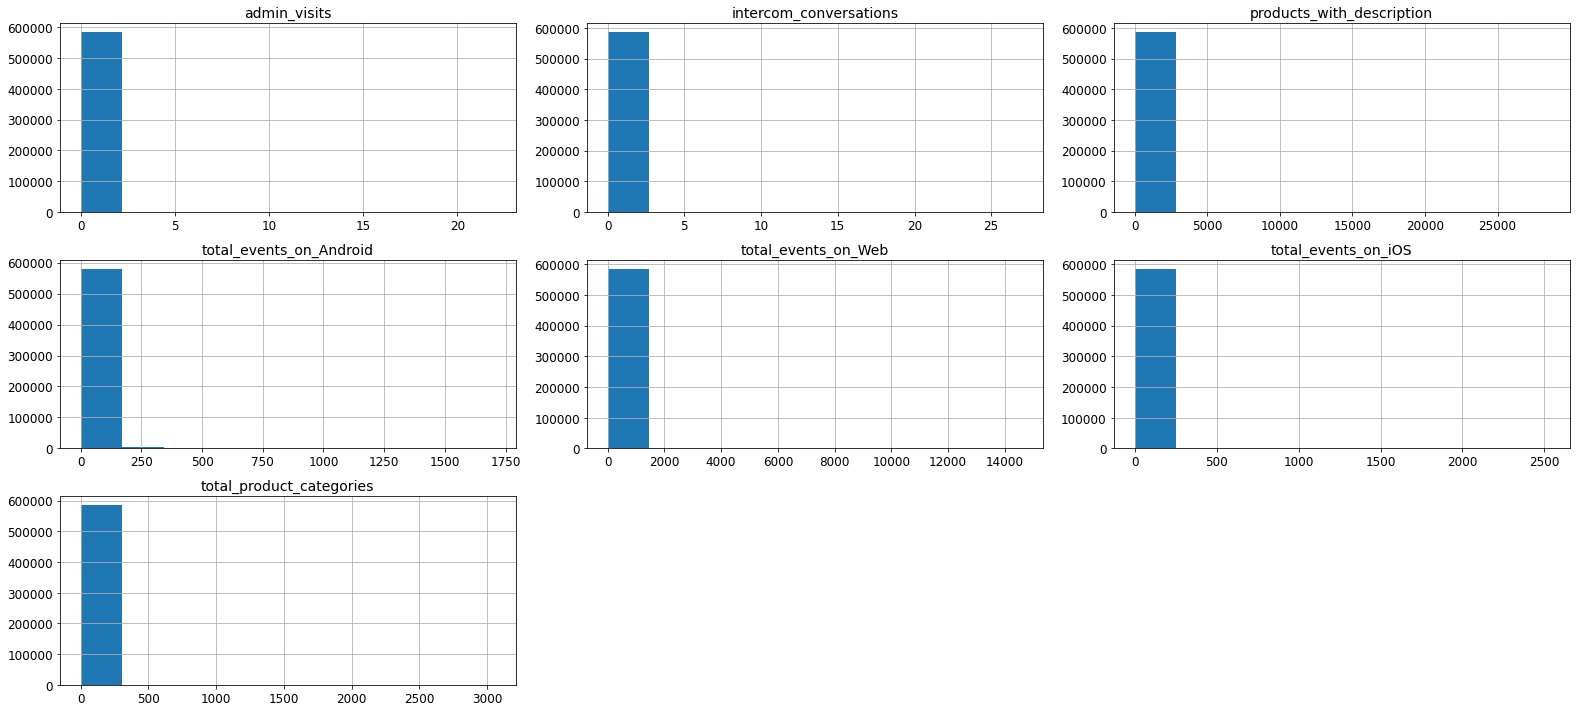

In [17]:
plot_utils.display_dataset_distributions(X_float)

<AxesSubplot:>

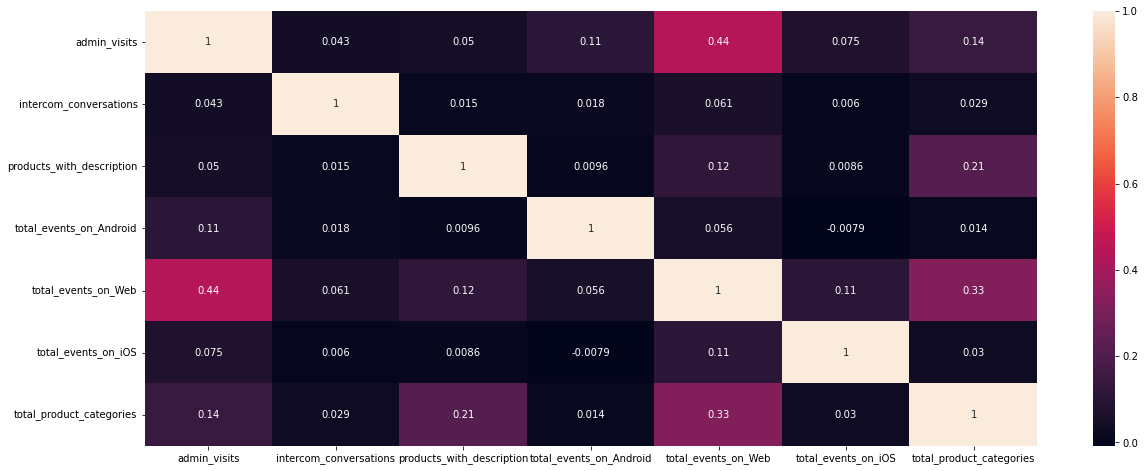

In [18]:
corrmat = X_float.corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corrmat, annot=True, square=False)

From the correlation matrix above it can be seen that there are no strongly correlated variables.

#### Integer variables

In [19]:
pd.concat([X_int.nunique(), X_int.nunique(dropna=False)], axis=1).T

,creation_hour,creation_weekday,id,total_products_with_images
0,24,7,585340,1102
1,24,7,585340,1102


No int column has missing values. The *id* column will no be considered fot the next analysis

In [20]:
X_int.drop(labels='id', axis=1, inplace=True)

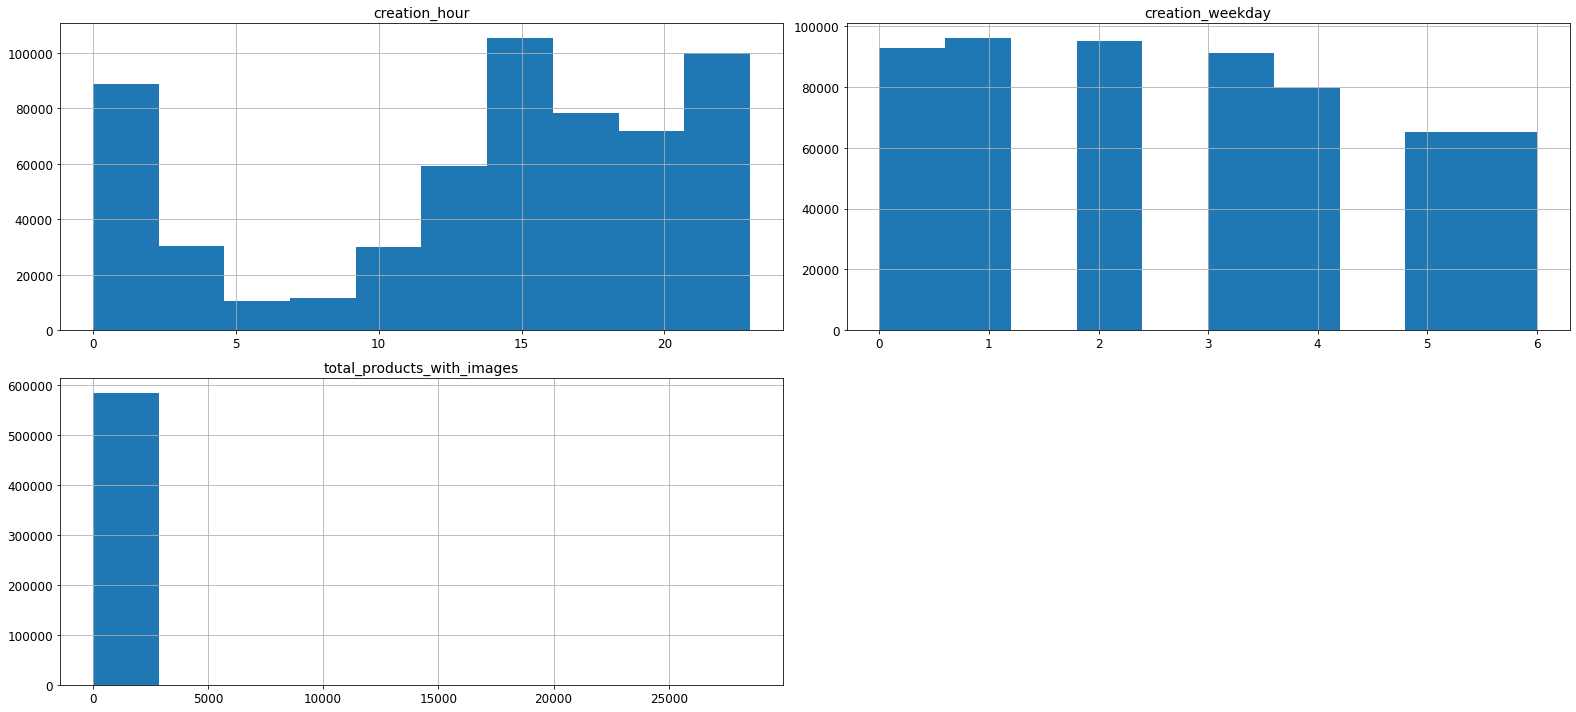

In [21]:
plot_utils.display_dataset_distributions(X_int)

*creation_weekday* and *creation_hour* should be considered as categorical variables

<AxesSubplot:>

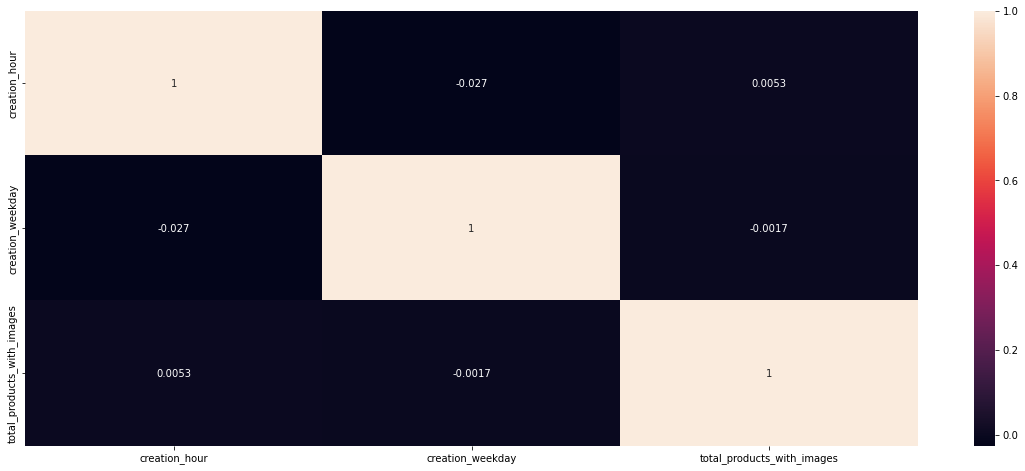

In [22]:
corrmat = X_int.corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corrmat, annot=True, square=False)

From the correlation matrix above it can be seen that there are no strongly correlated variables.

<AxesSubplot:>

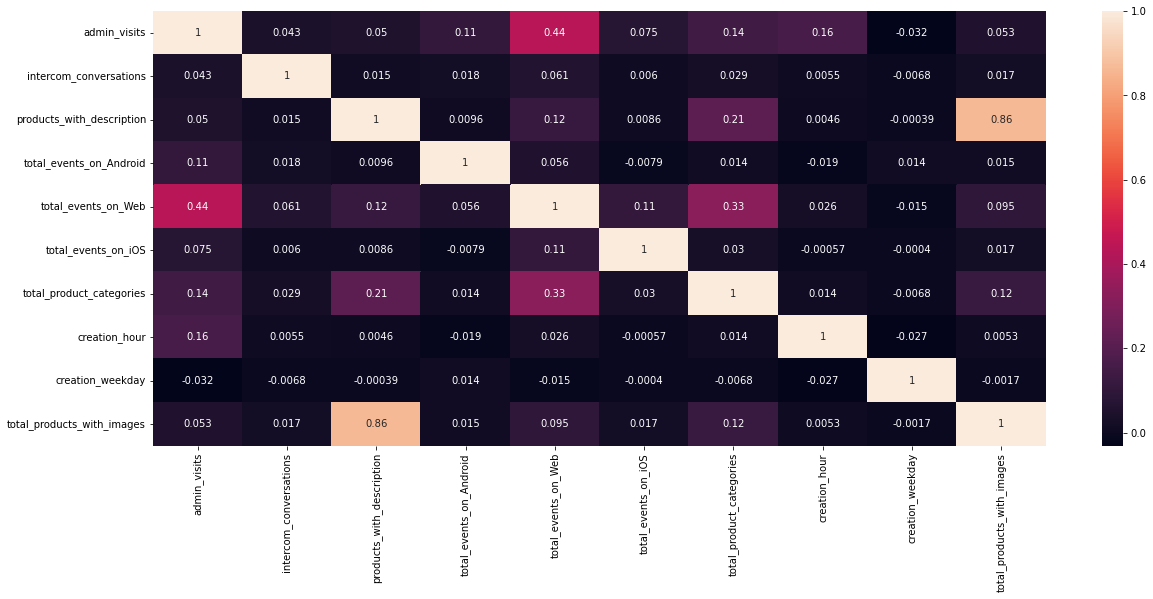

In [23]:
corrmat = pd.concat([X_float, X_int], axis=1).corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corrmat, annot=True, square=False)

From the correlation matrix above it can be seen that there are no strongly correlated variables (more than 0.9). It can be inferred that sellers who have products with images also add description (in most cases).

#### Categorical variables

In [24]:
X_categorical = pd.concat([X_categorical, X_int[['creation_weekday', 'creation_hour']]], axis=1)

In [25]:
X_int.drop(labels=['creation_weekday', 'creation_hour'], axis=1, inplace=True)

In [26]:
pd.concat([X_categorical.nunique(), X_categorical.nunique(dropna=False)], axis=1).T

,country,creation_platform,source_pulido,creation_weekday,creation_hour
0,5,4,12,7,24
1,5,4,12,7,24


No categorical column has missing values

/Users/ext_asalassa/Documents/CEIA/3erBim/machine-learning-1/TP_Final/utils/plot_utils.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


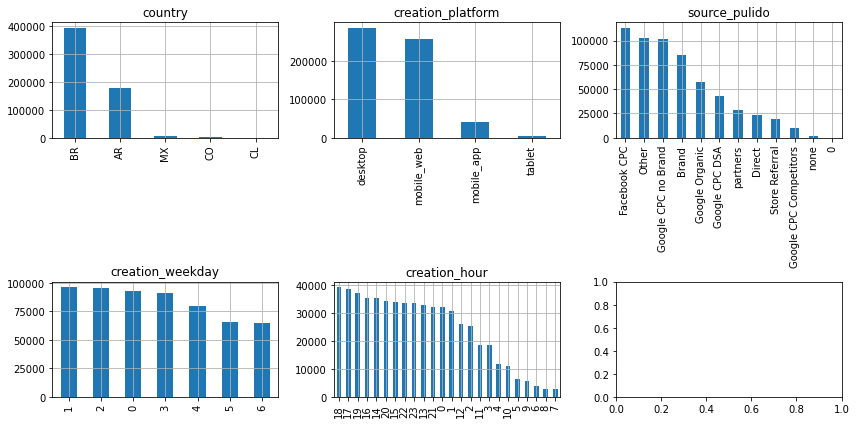

In [27]:
plot_utils.display_dataset_bar_value_count(X_categorical)

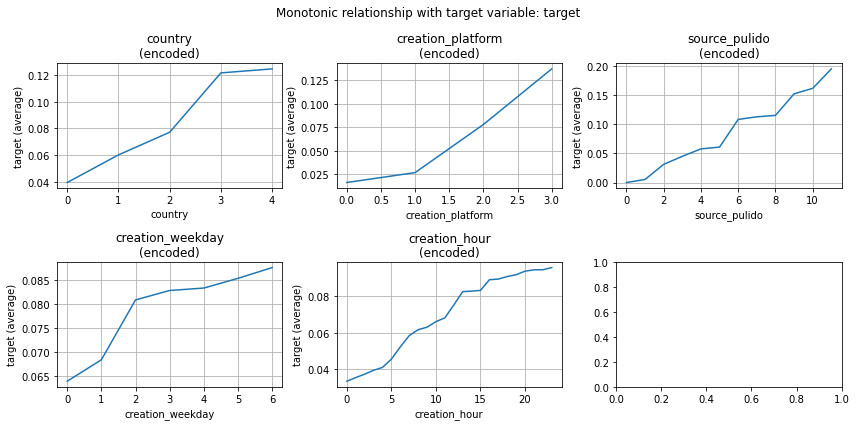

In [28]:
plot_utils.plot_cat_var_relations(X_categorical, Y, column_names=list(X_categorical.columns), label_name=label)

It is observed that all the categorical variables have a monotonic relationship with the target variable. So including them in the classification model would add value.

#### Label

In [29]:
print("Number of distinct values:", Y.nunique())
print("Number of distinct values including missing_values:", Y.nunique(dropna=False))
print("The possible values of Y are:", Y.unique())

Number of distinct values: 2
Number of distinct values including missing_values: 2
The possible values of Y are: [0 1]


There are no missing values in the target column

In [30]:
Y.value_counts()

0    538471
1     46869
Name: target, dtype: int64

In [31]:
y_aux = Y.value_counts()
print('percentage of trails that became payment:', 100*y_aux[1]/np.sum(y_aux))
print('percentage of trails that did not become payment:', 100*y_aux[0]/np.sum(y_aux))

percentage of trails that became payment: 8.00714114873407
percentage of trails that did not become payment: 91.99285885126594


The data is highly imabalanced. Class weights can be used for training

___
## 2. Train-test split

In [32]:
Y = df[label]
X = pd.concat([X_categorical, X_float, X_int], axis=1)
print(len(Y))
print(len(X))
print(X.columns)

585340
585340
Index(['country', 'creation_platform', 'source_pulido', 'creation_weekday',
       'creation_hour', 'admin_visits', 'intercom_conversations',
       'products_with_description', 'total_events_on_Android',
       'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images'],
      dtype='object')


In [33]:
train_proportion = 0.8
#val_proportion = 0.1
test_propportion = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=train_proportion, test_size=test_propportion, stratify=Y)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=train_proportion, test_size=val_proportion+test_propportion)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=val_proportion/(val_proportion+test_propportion), test_size=test_propportion/(val_proportion+test_propportion))

In [34]:
# Reset index is needed to perform transformations
X_train = X_train.reset_index()
#X_val = X_val.reset_index()
X_test = X_test .reset_index()

In [35]:
print("Dataset length:", len(X))
print("Training set length:", len(X_train))
#print("Validation set length:", len(X_val))
print("Test set length:", len(X_test))

Dataset length: 585340
Training set length: 468272
Test set length: 117068


___
## 4. Testing data preprocessing

### 4.1 Categorical variables

Mapping weekdays to avoid column name overlapping 

In [36]:
X_train['creation_weekday'] = X_train['creation_weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
X_train['creation_weekday']

0          Thursday
1         Wednesday
2           Tuesday
3          Thursday
4          Saturday
            ...    
468267     Saturday
468268    Wednesday
468269     Thursday
468270     Thursday
468271       Monday
Name: creation_weekday, Length: 468272, dtype: object

In [37]:
df_ohe = transformer.one_hot_encoding(X_train[list(X_categorical.columns)])
df_ohe.head()

,AR,BR,CL,CO,MX,desktop,mobile_app,mobile_web,tablet,0,...,14,15,16,17,18,19,20,21,22,23
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Check
pd.concat((X_train[['creation_weekday']], df_ohe[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]), axis=1)

,creation_weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,Thursday,0,0,0,1,0,0,0
1,Wednesday,0,0,1,0,0,0,0
2,Tuesday,0,1,0,0,0,0,0
3,Thursday,0,0,0,1,0,0,0
4,Saturday,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
468267,Saturday,0,0,0,0,0,1,0
468268,Wednesday,0,0,1,0,0,0,0
468269,Thursday,0,0,0,1,0,0,0
468270,Thursday,0,0,0,1,0,0,0


___
## 5. Feature seletion analysis

### 5.1 Numeric variables correlation

In [39]:
# Columnas inicialmente numéricas, previo a transformar.
columns_to_correlate = list(X_float.columns) + list(X_int.columns)
columns_to_correlate

['admin_visits',
 'intercom_conversations',
 'products_with_description',
 'total_events_on_Android',
 'total_events_on_Web',
 'total_events_on_iOS',
 'total_product_categories',
 'total_products_with_images']

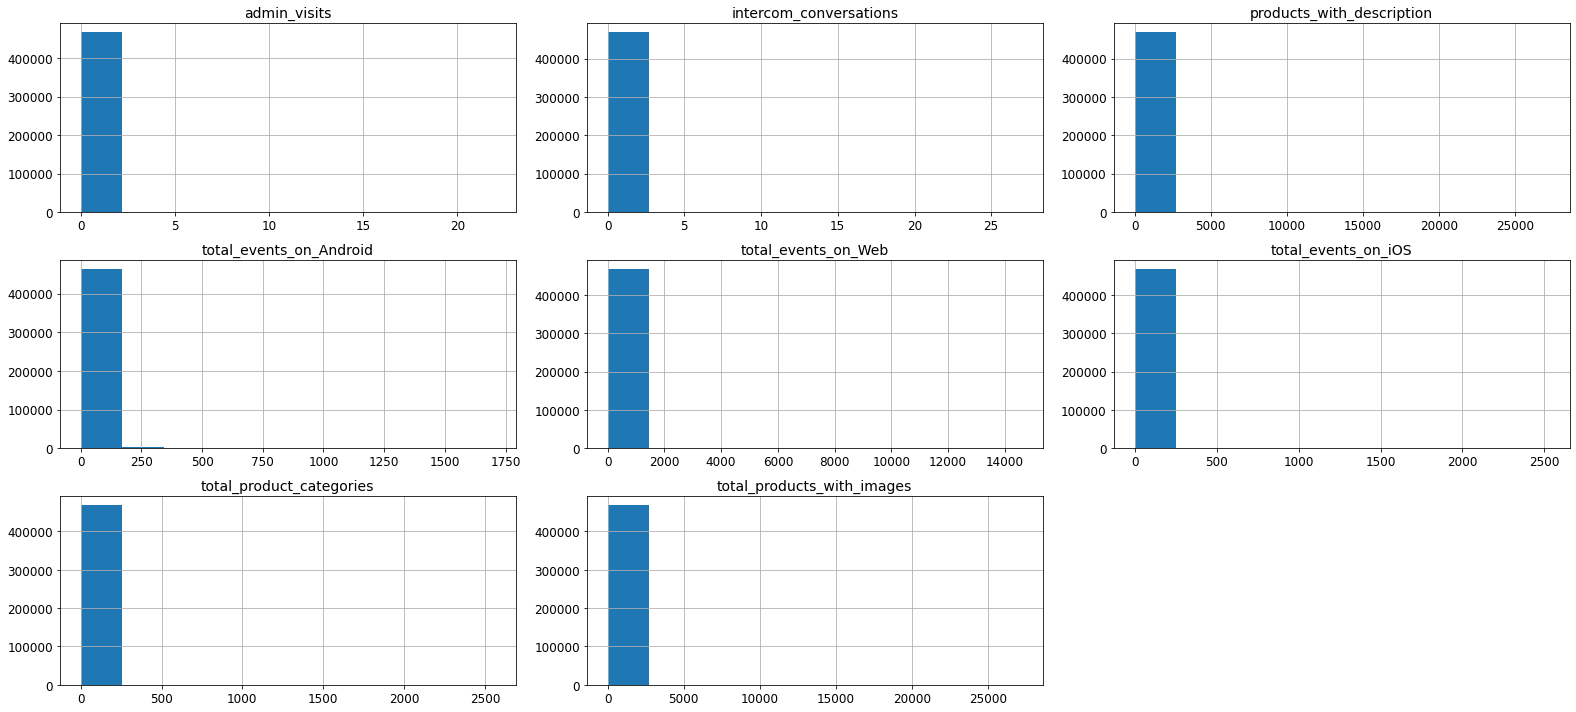

In [40]:
# Correlación sin normalizar
df_corr = X_train[columns_to_correlate].copy()
plot_utils.display_dataset_distributions(df_corr)

<AxesSubplot:>

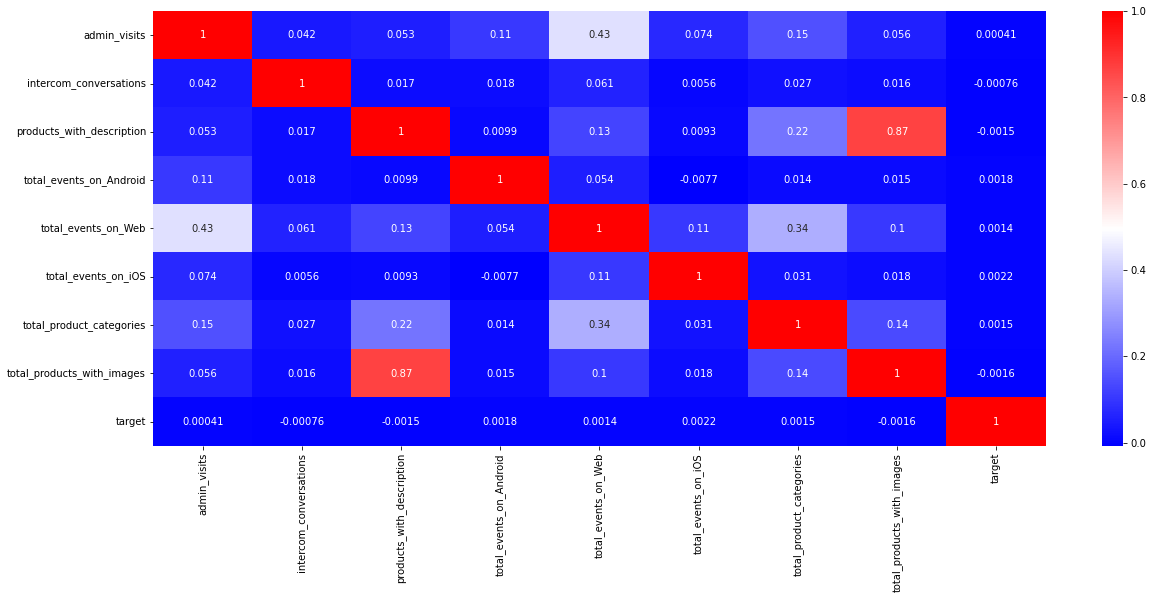

In [41]:
corr_mtx = pd.concat((df_corr, y_train), axis=1).corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corr_mtx, annot=True, square=False, cmap='bwr')

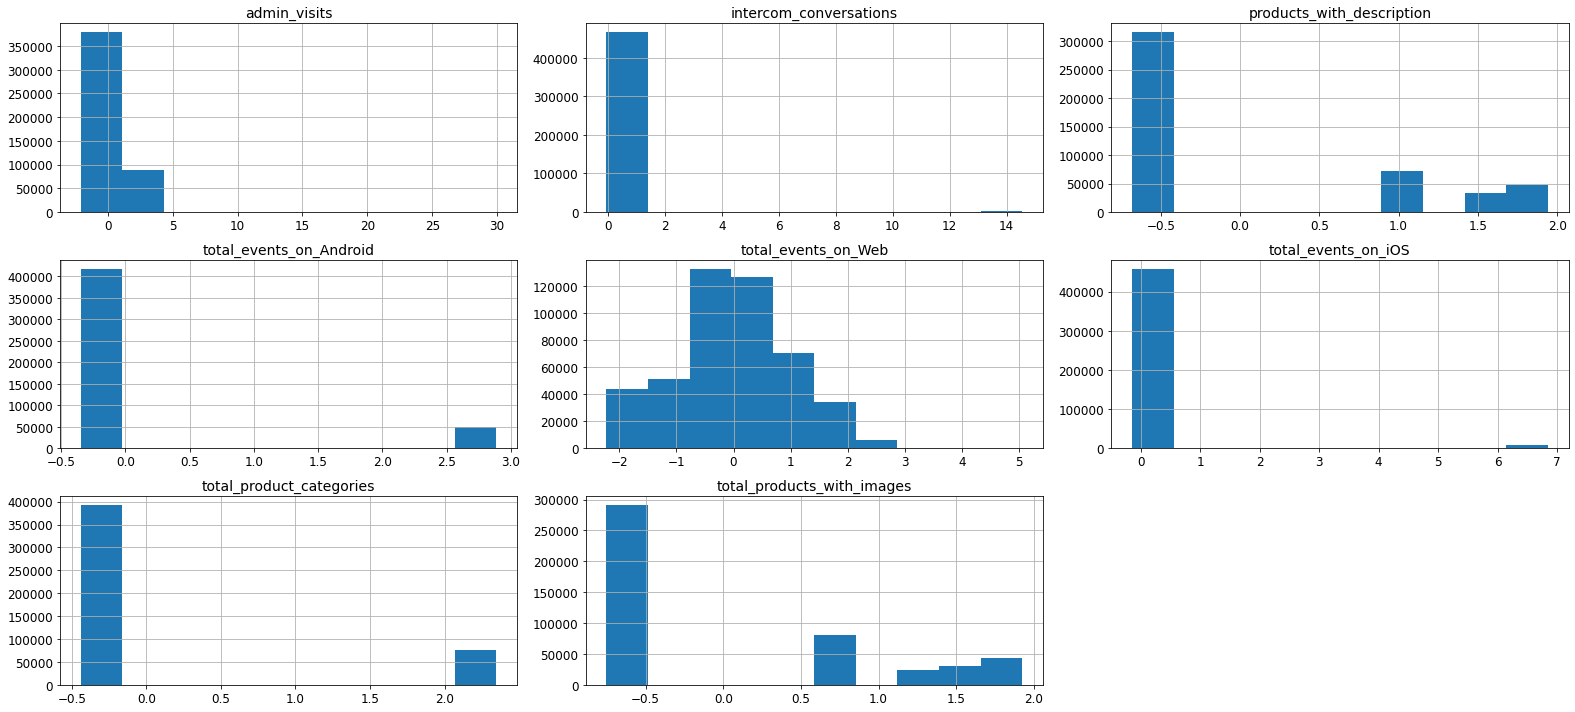

In [42]:
# Correlación normalizando normalizar
df_corr = transformer.power_transform(df_corr)
plot_utils.display_dataset_distributions(df_corr)

<AxesSubplot:>

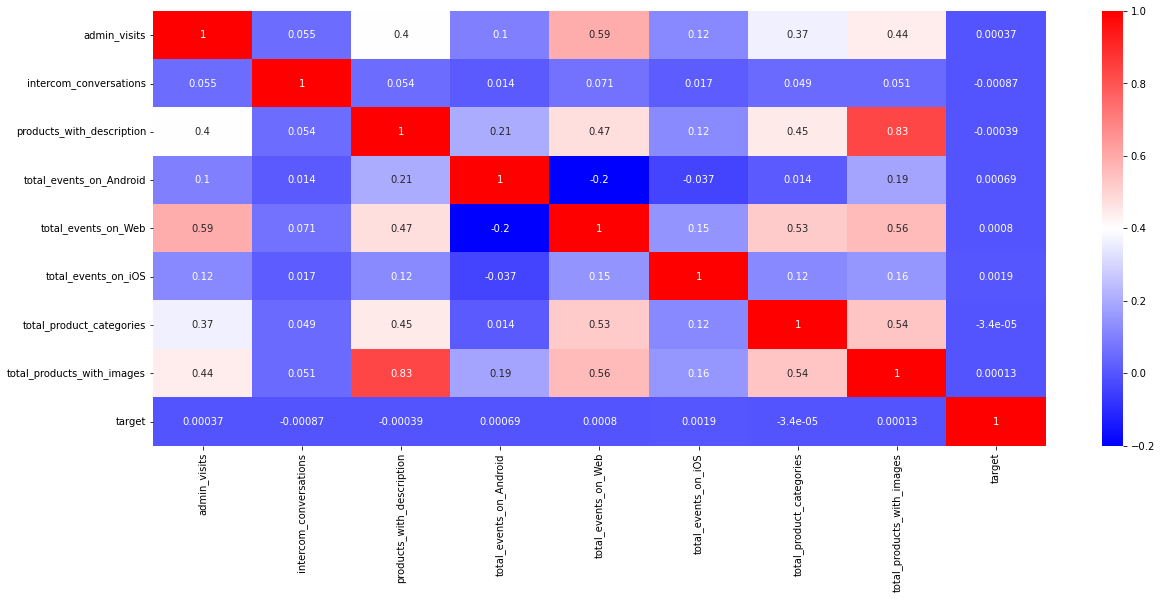

In [43]:
corr_mtx = pd.concat((df_corr, y_train), axis=1).corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corr_mtx, annot=True, square=False, cmap='bwr')

### 5.2 Mutual information

In [44]:
from sklearn.feature_selection import mutual_info_regression

MI = mutual_info_regression(X_train[columns_to_correlate], y_train)

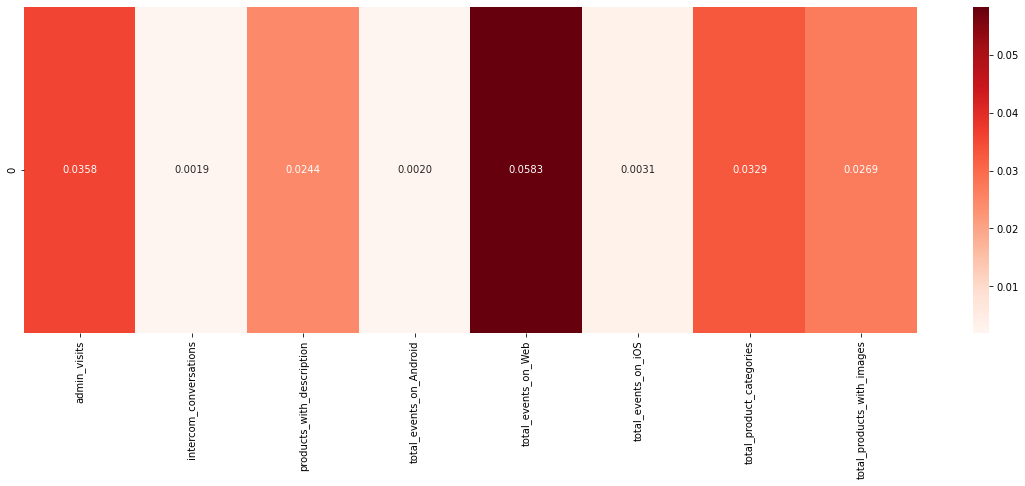

In [45]:
fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.heatmap([MI], ax=ax, cmap='Reds', annot=True,fmt=".4f").set_xticklabels(columns_to_correlate)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

Surprisingly there is no mutual information between the Android mobile events and the target

In [46]:
columns_reduced = [
    'admin_visits',
    #'intercom_conversations',
    'products_with_description',
    #'total_events_on_Android',
    'total_events_on_Web',
    #'total_events_on_iOS',
    'total_product_categories',
    'total_products_with_images',
    #'total_mobile'
 ]

In [47]:
# Trying more variables
X_train['total_events'] = X_train[['total_events_on_Web', 'total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)
X_train['total_mobile'] = X_train[['total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)
ext_cols = ['total_events', 'total_mobile']

In [48]:
columns_0 = columns_to_correlate

In [49]:
columns_1 = [
    'admin_visits',
    'intercom_conversations',
    'products_with_description',
    #'total_events_on_Android',
    'total_events_on_Web',
    #'total_events_on_iOS',
    'total_product_categories',
    'total_products_with_images',
    'total_mobile'
 ]
MI_ext_1 = mutual_info_regression(X_train[columns_1], y_train)

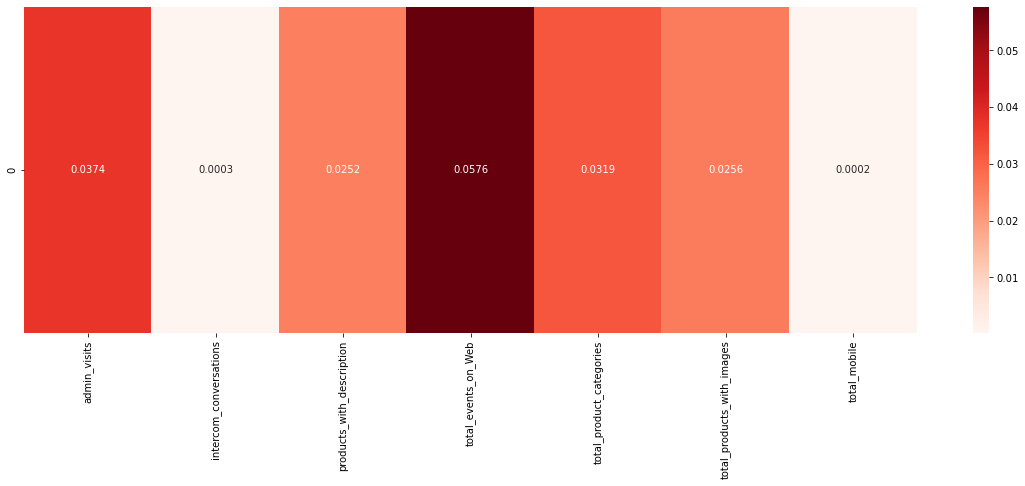

In [50]:
fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.heatmap([MI_ext_1], ax=ax, cmap='Reds', annot=True,fmt=".4f").set_xticklabels(columns_1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [51]:
columns_2 = [
    'admin_visits',
    'intercom_conversations',
    'products_with_description',
    #'total_events_on_Android',
    #'total_events_on_Web',
    #'total_events_on_iOS',
    'total_product_categories',
    'total_products_with_images',
    #'total_mobile',
    'total_events'
 ]
MI_ext_2 = mutual_info_regression(X_train[columns_2], y_train)

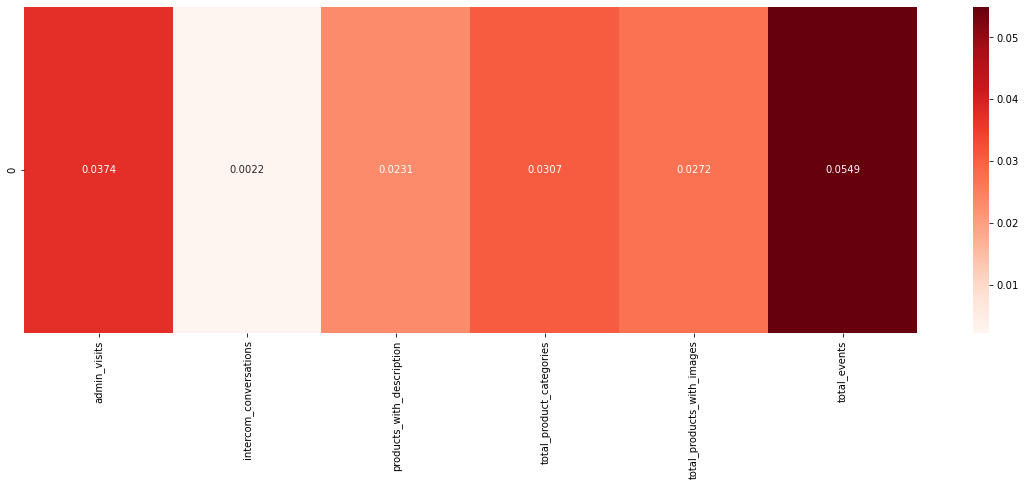

In [52]:
fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.heatmap([MI_ext_2], ax=ax, cmap='Reds', annot=True,fmt=".4f").set_xticklabels(columns_2)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#### Define different feature sets based on the previous graphics

In [53]:
fs_0 = list(set(columns_0).union(set(X_categorical.columns)))
fs_1 = list(set(columns_1).union(set(X_categorical.columns)))
fs_2 = list(set(columns_2).union(set(X_categorical.columns)))
fs_3 = list(set(columns_reduced).union(set(X_categorical.columns)))

print('fs_0 - Length:', len(fs_0), fs_0, '\n')
print('fs_1 - Length:', len(fs_1), fs_1, '\n')
print('fs_2 - Length:', len(fs_2), fs_2, '\n')
print('fs_3 - Length:', len(fs_3), fs_3, '\n')

fs_0 - Length: 13 ['creation_platform', 'intercom_conversations', 'admin_visits', 'source_pulido', 'products_with_description', 'total_events_on_Android', 'total_events_on_Web', 'creation_weekday', 'total_events_on_iOS', 'total_products_with_images', 'creation_hour', 'country', 'total_product_categories'] 

fs_1 - Length: 12 ['creation_platform', 'intercom_conversations', 'admin_visits', 'source_pulido', 'products_with_description', 'total_events_on_Web', 'creation_weekday', 'total_mobile', 'total_products_with_images', 'creation_hour', 'country', 'total_product_categories'] 

fs_2 - Length: 11 ['creation_platform', 'intercom_conversations', 'admin_visits', 'source_pulido', 'products_with_description', 'total_events', 'creation_weekday', 'creation_hour', 'total_products_with_images', 'country', 'total_product_categories'] 

fs_3 - Length: 10 ['creation_platform', 'admin_visits', 'source_pulido', 'products_with_description', 'total_events_on_Web', 'creation_weekday', 'creation_hour', 't

___
## 6. Training model and evaluation

### 6.0 Complete and transform test set

In [54]:
X_test['total_events'] = X_test[['total_events_on_Web', 'total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)
X_test['total_mobile'] = X_test[['total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)

In [55]:
X_test['creation_weekday'] = X_test['creation_weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

### 6.1 Input data preprocesor pipelines

In [56]:
from sklearn.preprocessing import RobustScaler, StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(categories="auto", drop=None, sparse=False, handle_unknown="ignore")
)])

categorical_transformer = OneHotEncoder(categories="auto", drop=None, sparse=False, handle_unknown="ignore")

preprocessor_0 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_0),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_1),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_2),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_reduced),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

### 6.2 Model trainings

In [285]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [58]:
results = {}

#### 6.2.1 Logistic Regression

In [59]:
modelLR_0 = Pipeline(steps=[
                            ('preprocessor', preprocessor_0),
                            ('classifier', LogisticRegression(verbose=True, max_iter=50, tol = 0.00001))
                            ],
                    verbose=True)

In [60]:
modelLR_0.fit(X_train[fs_0], y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   3.3s


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Android',
                                                   'total_events_on_Web',
                                                   'total_events_on_iOS',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown

Accuracy: 92.02%


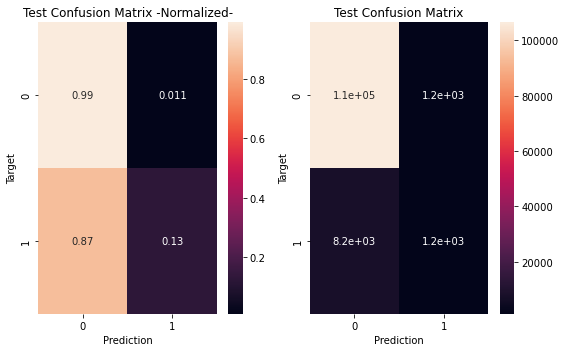

In [69]:
test_preds_LR_0 = modelLR_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_LR_0, y_test, 'Test')
acc = modelLR_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_0)

<ipython-input-66-77603edeaa6a>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


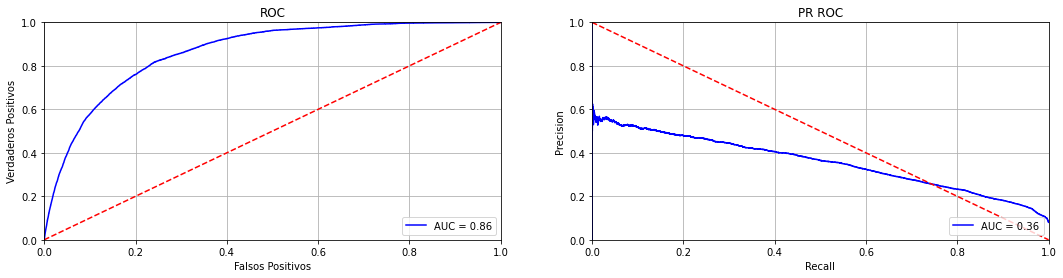

In [66]:
y_pred_LR_0 = modelLR_0.predict_proba(X_test[fs_0])

preds_LR_0 = y_pred_LR_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_0)
roc_auc_LR_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_0)
pr_roc_auc_LR_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [70]:
results['modelLR_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_0, 'prc': pr_roc_auc_LR_0}
results['modelLR_0']

{'acc': 0.9201916834660198,
 'rec': 0.12854704501813527,
 'f1': 0.20505402875861484,
 'auc': 0.8642121026445866,
 'prc': 0.3564205923718762}

___

In [71]:
modelLR_1 = Pipeline(steps = [
                            ('preprocessor', preprocessor_1),
                            ('classifier', LogisticRegression(verbose=True, max_iter=50, tol = 0.00001))
                            ],
                    verbose=True)

In [72]:
modelLR_1.fit(X_train[fs_1], y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   3.9s


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_mobile']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=Fal

Accuracy: 92.08%


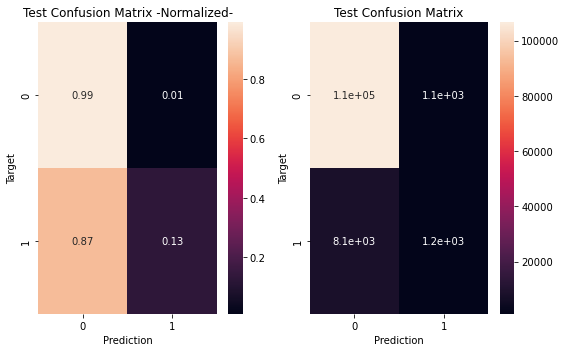

In [73]:
test_preds_LR_1 = modelLR_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_LR_1, y_test, 'Test')
acc = modelLR_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_1)

<ipython-input-74-d04535c8be60>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


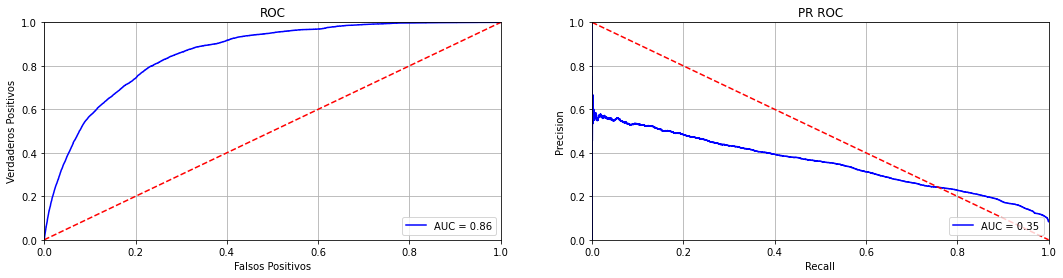

In [74]:
y_pred_LR_1 = modelLR_1.predict_proba(X_test[fs_1])

preds_LR_1 = y_pred_LR_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_1)
roc_auc_LR_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_1)
pr_roc_auc_LR_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [75]:
results['modelLR_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_1, 'prc': pr_roc_auc_LR_1}
results['modelLR_1']

{'acc': 0.9208408788054806,
 'rec': 0.1317473863878814,
 'f1': 0.21044559938655535,
 'auc': 0.8598006176687966,
 'prc': 0.3524670934742969}

___

In [76]:
modelLR_2 = Pipeline(steps=[('preprocessor', preprocessor_2),
                       ('classifier', LogisticRegression(verbose=True, max_iter=50, tol = 0.00001))])

In [77]:
modelLR_2.fit(X_train[fs_2], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_events']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
       

Accuracy: 92.07%


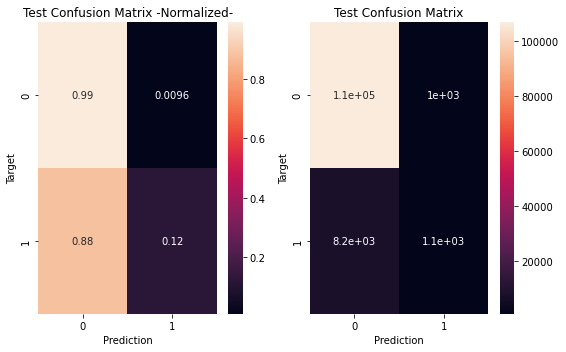

In [78]:
test_preds_LR_2 = modelLR_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_LR_2, y_test, 'Test')
acc = modelLR_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_2)

<ipython-input-79-b7bb523ac856>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


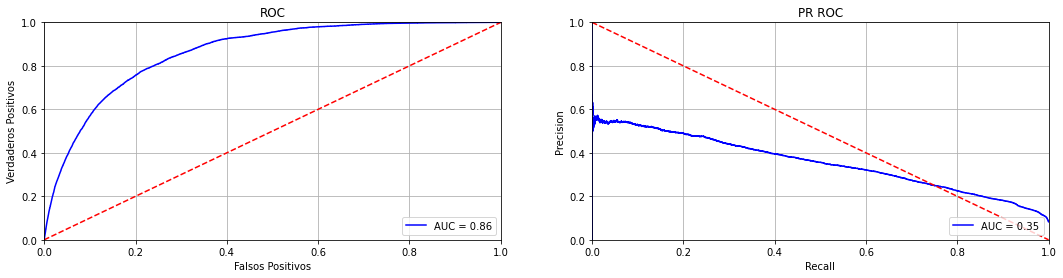

In [79]:
y_pred_LR_2 = modelLR_2.predict_proba(X_test[fs_2])

preds_LR_2 = y_pred_LR_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_2)
roc_auc_LR_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_2)
pr_roc_auc_LR_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [80]:
results['modelLR_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_2, 'prc': pr_roc_auc_LR_2}
results['modelLR_2']

{'acc': 0.9206700379266751,
 'rec': 0.12011947941113718,
 'f1': 0.19516422566946873,
 'auc': 0.8623257672652068,
 'prc': 0.35446695559822505}

___

In [81]:
modelLR_3 = Pipeline(steps=[('preprocessor', preprocessor_3),
                       ('classifier', LogisticRegression(verbose=True, max_iter=50, tol = 0.00001))])

In [82]:
modelLR_3.fit(X_train[fs_3], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
                                                   'creation_platform',
     

Accuracy: 92.07%


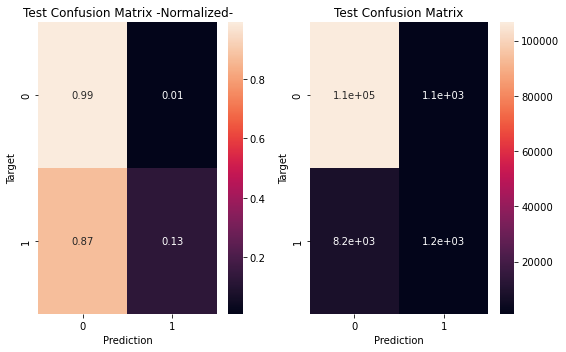

In [83]:
test_preds_LR_3 = modelLR_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_LR_3, y_test, 'Test')
acc = modelLR_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_3)

<ipython-input-84-e3974ef103d2>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


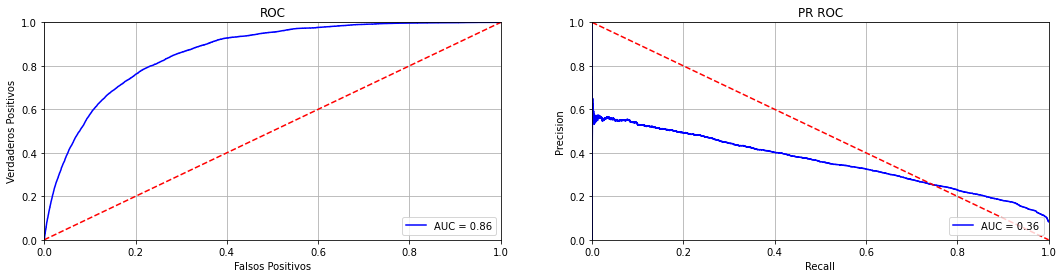

In [84]:
y_pred_LR_3 = modelLR_3.predict_proba(X_test[fs_3])

preds_LR_3 = y_pred_LR_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_3)
roc_auc_LR_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_3)
pr_roc_auc_LR_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [85]:
results['modelLR_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_3, 'prc': pr_roc_auc_LR_3}
results['modelLR_3']

{'acc': 0.9207127481463765,
 'rec': 0.12758694260721143,
 'f1': 0.20489977728285078,
 'auc': 0.863938973307127,
 'prc': 0.35891949529913814}

#### 6.2.2 Random forest

In [88]:
modelRF_0 = Pipeline(steps=[('preprocessor', preprocessor_0),
                       ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, random_state=0))])

In [89]:
modelRF_0.fit(X_train[fs_0], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Android',
                                                   'total_events_on_Web',
                                                   'total_events_on_iOS',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown

Accuracy: 91.34%


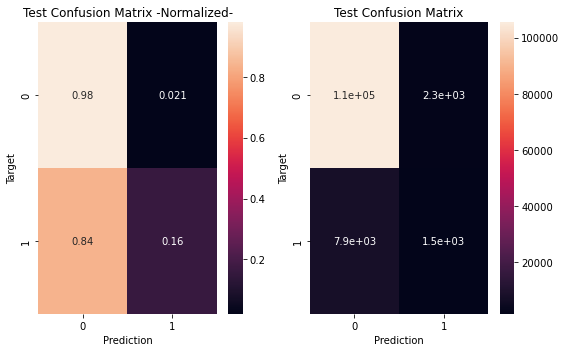

In [90]:
test_preds_RF_0 = modelRF_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_RF_0, y_test, 'Test')
acc = modelRF_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_0)

<ipython-input-91-5dd9bcfb54c3>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


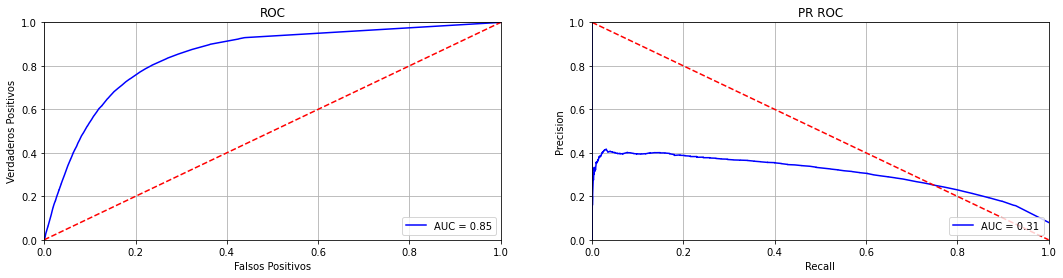

In [91]:
y_pred_RF_0 = modelRF_0.predict_proba(X_test[fs_0])

preds_RF_0 = y_pred_RF_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_0)
roc_auc_RF_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_0)
pr_roc_auc_RF_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [92]:
results['modelRF_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_0, 'prc': pr_roc_auc_RF_0}
results['modelRF_0']

{'acc': 0.9134178426213825,
 'rec': 0.1596970343503307,
 'f1': 0.22802741812642804,
 'auc': 0.8451949431282018,
 'prc': 0.3058977070937976}

___

In [97]:
modelRF_1 = Pipeline(steps=[('preprocessor', preprocessor_1),
                       ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, random_state=0))])

In [98]:
modelRF_1.fit(X_train[fs_1], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_mobile']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=Fal

Accuracy: 91.34%


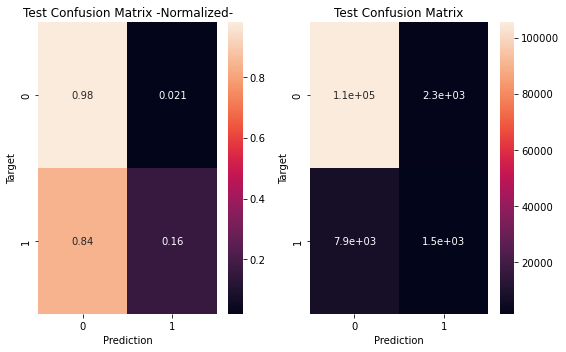

In [99]:
test_preds_RF_1 = modelRF_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_RF_1, y_test, 'Test')
acc = modelRF_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_1)

<ipython-input-100-b9313fc5ab1c>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


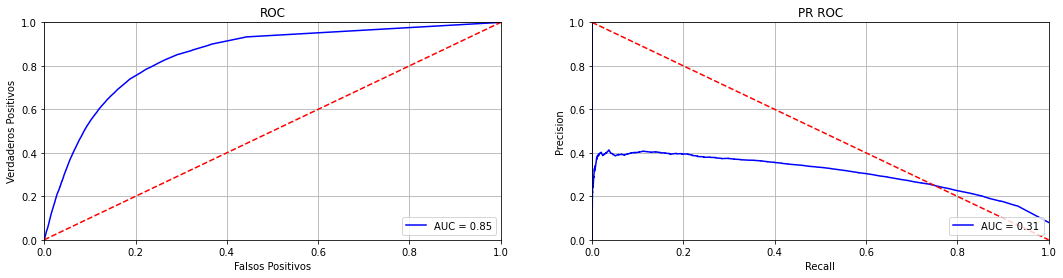

In [100]:
y_pred_RF_1 = modelRF_1.predict_proba(X_test[fs_1])

preds_RF_1 = y_pred_RF_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_1)
roc_auc_RF_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_1)
pr_roc_auc_RF_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [101]:
results['modelRF_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_1, 'prc': pr_roc_auc_RF_1}
results['modelRF_1']

{'acc': 0.9133665903577408,
 'rec': 0.16001706848730532,
 'f1': 0.22827575711459444,
 'auc': 0.8455768262429728,
 'prc': 0.3066677053465181}

___

In [102]:
modelRF_2 = Pipeline(steps=[('preprocessor', preprocessor_2),
                       ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, random_state=0))])

In [103]:
modelRF_2.fit(X_train[fs_2], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_events']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
       

Accuracy: 91.25%


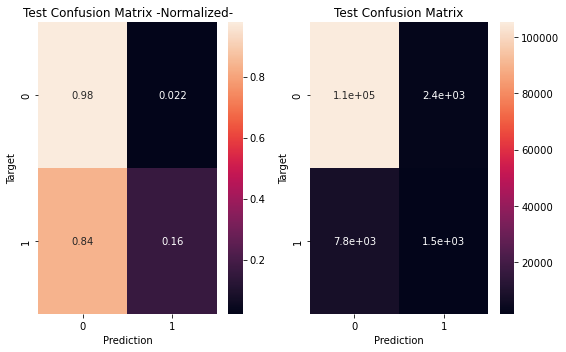

In [104]:
test_preds_RF_2 = modelRF_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_RF_2, y_test, 'Test')
acc = modelRF_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_2)

<ipython-input-105-dce0f61cf5d7>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


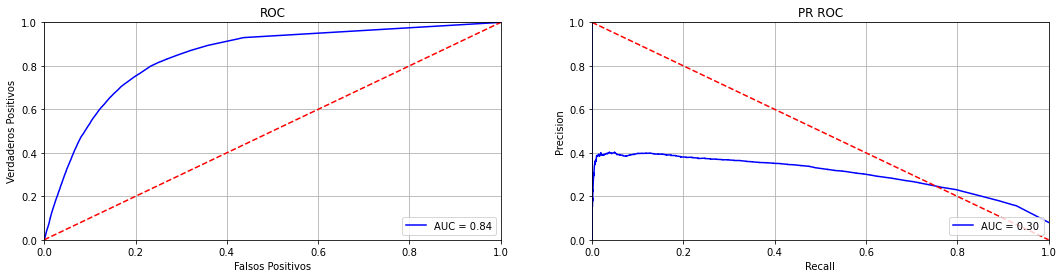

In [105]:
y_pred_RF_2 = modelRF_2.predict_proba(X_test[fs_2])

preds_RF_2 = y_pred_RF_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_2)
roc_auc_RF_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_2)
pr_roc_auc_RF_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [106]:
results['modelRF_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_2, 'prc': pr_roc_auc_RF_2}
results['modelRF_2']

{'acc': 0.9125465541394745,
 'rec': 0.1632174098570514,
 'f1': 0.23010979094600692,
 'auc': 0.844008818254856,
 'prc': 0.30318196007713927}

___

In [107]:
modelRF_3 = Pipeline(steps=[('preprocessor', preprocessor_3),
                       ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, random_state=0))])

In [108]:
modelRF_3.fit(X_train[fs_3], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
                                                   'creation_platform',
     

Accuracy: 91.28%


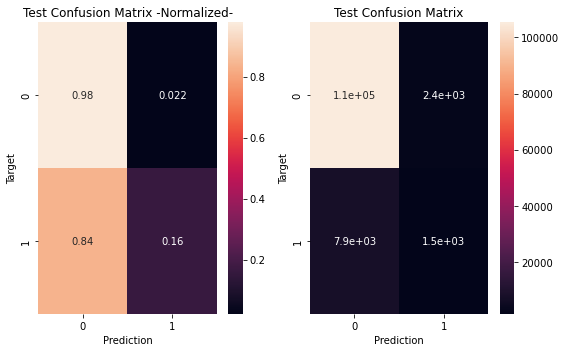

In [109]:
test_preds_RF_3 = modelRF_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_RF_3, y_test, 'Test')
acc = modelRF_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_3)

<ipython-input-110-ada330219aa6>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


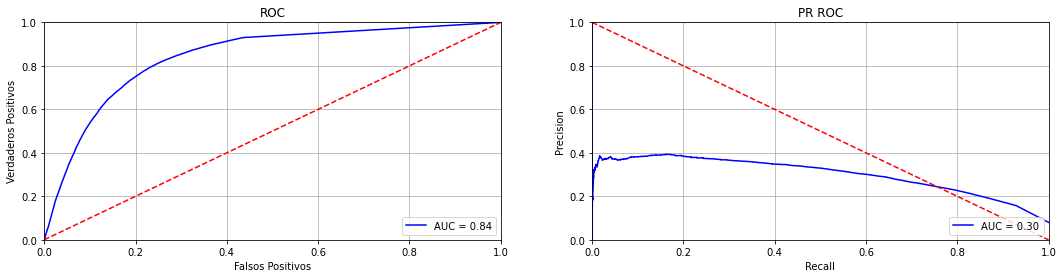

In [110]:
y_pred_RF_3 = modelRF_3.predict_proba(X_test[fs_3])

preds_RF_3 = y_pred_RF_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_3)
roc_auc_RF_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_3)
pr_roc_auc_RF_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [111]:
results['modelRF_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_3, 'prc': pr_roc_auc_RF_3}
results['modelRF_3']

{'acc': 0.9127942734137424,
 'rec': 0.16183059526349478,
 'f1': 0.22910216718266252,
 'auc': 0.8435374250940214,
 'prc': 0.3002906271416095}

#### 6.2.3 Neural Network

In [128]:
modelNN_0 = Pipeline(steps=[
    ('preprocessor', preprocessor_0),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, learning_rate_init=0.01, hidden_layer_sizes=(32,16,8,4,2), activation='relu', solver='adam', max_iter=10, alpha=0.001, random_state=0))
])

In [129]:
modelNN_0.fit(X_train[fs_0], y_train)

Iteration 1, loss = 0.21125975
Iteration 2, loss = 0.20061729
Iteration 3, loss = 0.19995546
Iteration 4, loss = 0.19864794
Iteration 5, loss = 0.19912045
Iteration 6, loss = 0.19890385
Iteration 7, loss = 0.19826367
Iteration 8, loss = 0.19902132
Iteration 9, loss = 0.19865264
Iteration 10, loss = 0.19806031


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Android',
                                                   'total_events_on_Web',
                                                   'total_events_on_iOS',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown

Accuracy: 91.83%


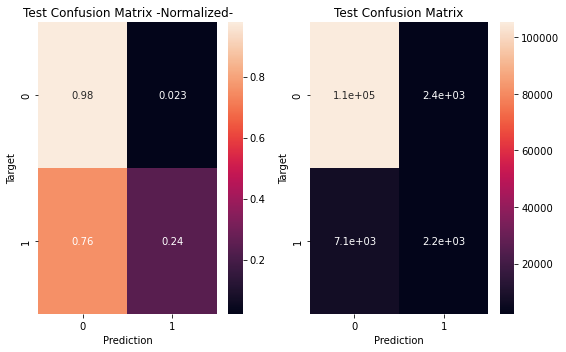

In [130]:
test_preds_NN_0 = modelNN_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_NN_0, y_test, 'Test')
acc = modelNN_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_0)

<ipython-input-131-83cb0fc8e883>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


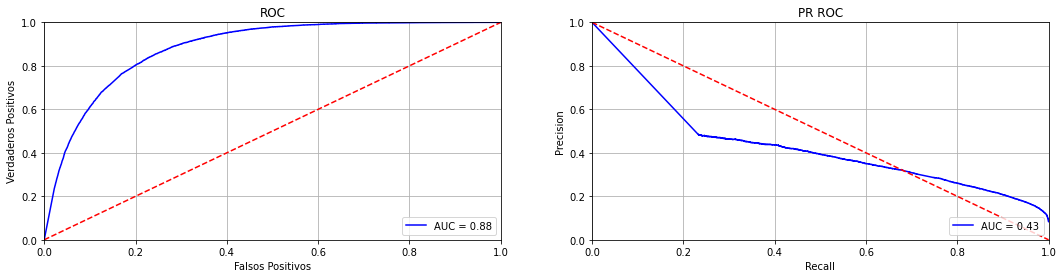

In [131]:
y_pred_NN_0 = modelNN_0.predict_proba(X_test[fs_0])

preds_NN_0 = y_pred_NN_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_0)
roc_auc_NN_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_0)
pr_roc_auc_NN_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [132]:
results['modelNN_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_0, 'prc': pr_roc_auc_NN_0}
results['modelNN_0']

{'acc': 0.9183466019749206,
 'rec': 0.23895882227437593,
 'f1': 0.31911104779542704,
 'auc': 0.8831579047373909,
 'prc': 0.43000214556867633}

___

In [156]:
modelNN_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, learning_rate_init=0.01, hidden_layer_sizes=(32,16,8,4,2), activation='relu', solver='adam', max_iter=20, alpha=0.001, random_state=1))
])

In [157]:
modelNN_1.fit(X_train[fs_1], y_train)

Iteration 1, loss = 0.22446139
Iteration 2, loss = 0.19993355
Iteration 3, loss = 0.20035765
Iteration 4, loss = 0.20012618
Iteration 5, loss = 0.19927446
Iteration 6, loss = 0.19977364
Iteration 7, loss = 0.19938555
Iteration 8, loss = 0.19893686
Iteration 9, loss = 0.19871050
Iteration 10, loss = 0.19929724
Iteration 11, loss = 0.19886067
Iteration 12, loss = 0.19876487
Iteration 13, loss = 0.19835284
Iteration 14, loss = 0.19805867
Iteration 15, loss = 0.19967771
Iteration 16, loss = 0.19846557
Iteration 17, loss = 0.19907446
Iteration 18, loss = 0.19844629
Iteration 19, loss = 0.19819999
Iteration 20, loss = 0.19842657


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_mobile']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=Fal

Accuracy: 92.15%


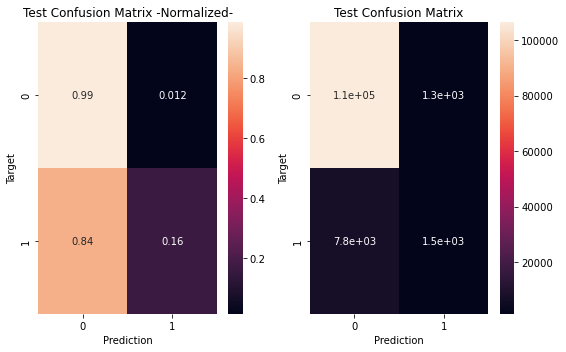

In [158]:
test_preds_NN_1 = modelNN_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_NN_1, y_test, 'Test')
acc = modelNN_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_1)

<ipython-input-161-5262c2d92ace>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


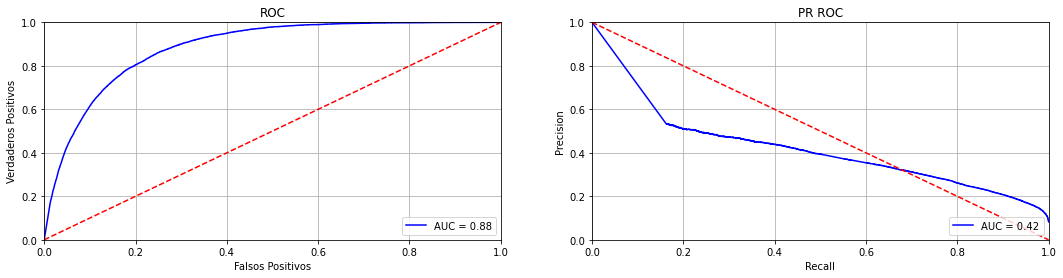

In [161]:
y_pred_NN_1 = modelNN_1.predict_proba(X_test[fs_1])

preds_NN_1 = y_pred_NN_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_1)
roc_auc_NN_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_1)
pr_roc_auc_NN_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [162]:
results['modelNN_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_1, 'prc': pr_roc_auc_NN_1}
results['modelNN_1']

{'acc': 0.9215157002767622,
 'rec': 0.16332408790270964,
 'f1': 0.2499591836734694,
 'auc': 0.884057509302933,
 'prc': 0.4203795538179742}

___

In [168]:
modelNN_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, learning_rate_init=0.01, hidden_layer_sizes=(32,16,8,4,2), activation='relu', solver='adam', max_iter=19, alpha=0.001, random_state=1))
])

In [169]:
modelNN_2.fit(X_train[fs_2], y_train)

Iteration 1, loss = 0.21210778
Iteration 2, loss = 0.20034300
Iteration 3, loss = 0.20071676
Iteration 4, loss = 0.19959068
Iteration 5, loss = 0.19899544
Iteration 6, loss = 0.19838494
Iteration 7, loss = 0.19809562
Iteration 8, loss = 0.19784789
Iteration 9, loss = 0.19920572
Iteration 10, loss = 0.19850380
Iteration 11, loss = 0.19862440
Iteration 12, loss = 0.19831672
Iteration 13, loss = 0.19807141
Iteration 14, loss = 0.19833175
Iteration 15, loss = 0.19786106
Iteration 16, loss = 0.19834318
Iteration 17, loss = 0.19785944
Iteration 18, loss = 0.19794174
Iteration 19, loss = 0.19747906


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_events']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
       

Accuracy: 91.99%


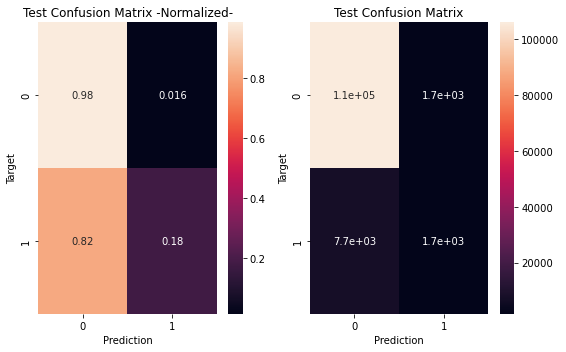

In [170]:
test_preds_NN_2 = modelNN_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_NN_2, y_test, 'Test')
acc = modelNN_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_2)

<ipython-input-171-ddaa5d2b5ea5>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


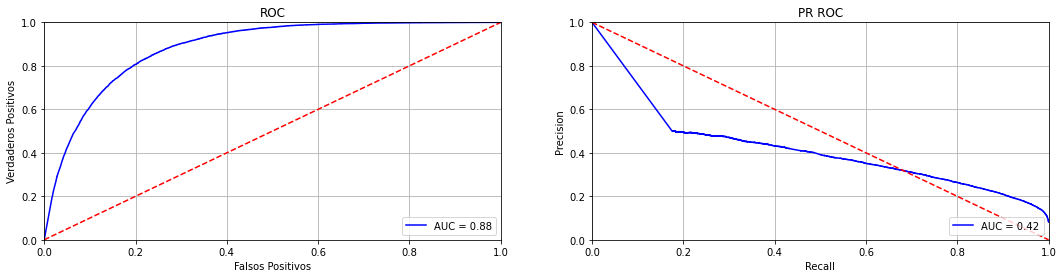

In [171]:
y_pred_NN_2 = modelNN_2.predict_proba(X_test[fs_2])

preds_NN_2 = y_pred_NN_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_2)
roc_auc_NN_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_2)
pr_roc_auc_NN_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [172]:
results['modelNN_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_2, 'prc': pr_roc_auc_NN_2}
results['modelNN_2']

{'acc': 0.9199268801038712,
 'rec': 0.17985918497973116,
 'f1': 0.26455358543856894,
 'auc': 0.8838312738687596,
 'prc': 0.4181051476774222}

___

In [174]:
modelNN_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, learning_rate_init=0.01, hidden_layer_sizes=(32,16,8,4,2), activation='relu', solver='adam', max_iter=19, alpha=0.001, random_state=1))
])

In [175]:
modelNN_3.fit(X_train[fs_3], y_train)

Iteration 1, loss = 0.20413659
Iteration 2, loss = 0.19899772
Iteration 3, loss = 0.19870685
Iteration 4, loss = 0.19853703
Iteration 5, loss = 0.19848580
Iteration 6, loss = 0.19828294
Iteration 7, loss = 0.19908491
Iteration 8, loss = 0.19830265
Iteration 9, loss = 0.19815584
Iteration 10, loss = 0.19792043
Iteration 11, loss = 0.19767723
Iteration 12, loss = 0.19795689
Iteration 13, loss = 0.19736906
Iteration 14, loss = 0.19722095
Iteration 15, loss = 0.19810970
Iteration 16, loss = 0.19753963
Iteration 17, loss = 0.19725138
Iteration 18, loss = 0.19724650
Iteration 19, loss = 0.19746762


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
                                                   'creation_platform',
     

Accuracy: 92.02%


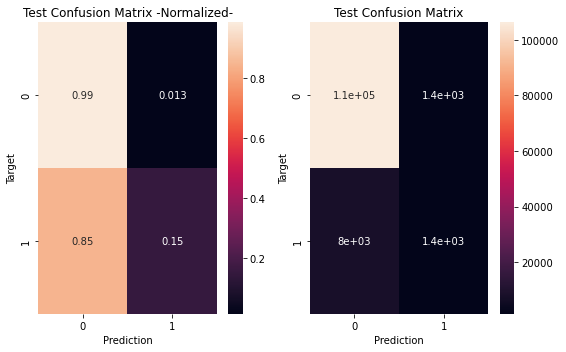

In [176]:
test_preds_NN_3 = modelNN_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_NN_3, y_test, 'Test')
acc = modelNN_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_3)

<ipython-input-177-031892fe047e>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


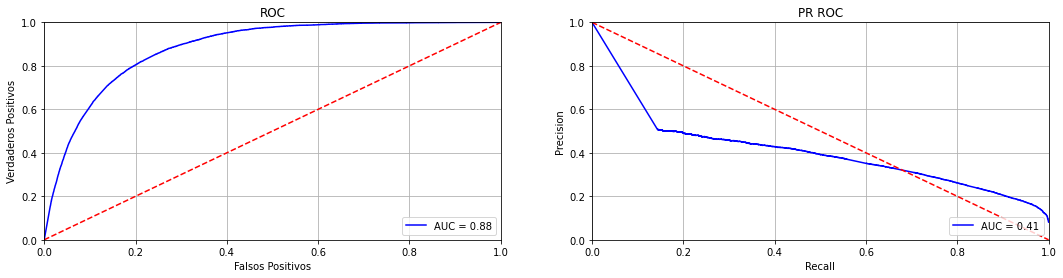

In [177]:
y_pred_NN_3 = modelNN_3.predict_proba(X_test[fs_3])

preds_NN_3 = y_pred_NN_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_3)
roc_auc_NN_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_3)
pr_roc_auc_NN_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [178]:
results['modelNN_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_3, 'prc': pr_roc_auc_NN_3}
results['modelNN_3']

{'acc': 0.9202002255099601,
 'rec': 0.14998933219543417,
 'f1': 0.23136415994734244,
 'auc': 0.8830568298299322,
 'prc': 0.4086689197678809}

___

#### 6.2.4 TF Neural Networks with cw

In [185]:
import tensorflow as tf
from tensorflow import feature_column

In [181]:
neg, pos = np.bincount(y_train)
weight_for_0 = (1 / neg) * ((neg+pos) / 2.0)
weight_for_1 = (1 / pos) * ((neg+pos) / 2.0)

Needed TF transformations

In [278]:
X_train_tf = X_train.copy()
X_test_tf = X_test.copy()

X_train_tf.columns

Index(['index', 'country', 'creation_platform', 'source_pulido',
       'creation_weekday', 'creation_hour', 'admin_visits',
       'intercom_conversations', 'products_with_description',
       'total_events_on_Android', 'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images',
       'total_events', 'total_mobile'],
      dtype='object')

In [280]:
df_tf_ohe = transformer.one_hot_encoding(X_train_tf[list(X_categorical.columns)])
X_train_tf = pd.concat([X_train_tf, df_tf_ohe], axis=1)
X_train_tf.head()

,index,country,creation_platform,source_pulido,creation_weekday,creation_hour,admin_visits,intercom_conversations,products_with_description,total_events_on_Android,...,14,15,16,17,18,19,20,21,22,23
0,337264,AR,mobile_web,Google CPC DSA,Thursday,22,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,190860,BR,mobile_web,Brand,Wednesday,5,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,518211,AR,desktop,Google Organic,Tuesday,14,0.0,0.0,2.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,98380,BR,mobile_web,Facebook CPC,Thursday,18,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,464269,BR,desktop,Google CPC DSA,Saturday,12,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [281]:
df_tf_ohe_test = transformer.one_hot_encoding(X_test_tf[list(X_categorical.columns)])
X_test_tf = pd.concat([X_test_tf, df_tf_ohe_test], axis=1)

In [282]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [310]:
def create_model():
  # create model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dense(units=8, activation='relu'))
  model.add(tf.keras.layers.Dense(units=4, activation='relu'))
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

  return model

model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=METRICS
)

___

In [311]:
rb_scaler = RobustScaler().fit(X_train_tf[columns_0])
X_train_tf[columns_0] = rb_scaler.transform(X_train_tf[columns_0])
X_test_tf[columns_0] = rb_scaler.transform(X_test_tf[columns_0])

In [312]:
history = model.fit(
    X_train_tf[list(df_tf_ohe.columns) + columns_0].values, 
    y_train.values,
    epochs=20,
    batch_size=128,
    class_weight={0: weight_for_0, 1: weight_for_1},
)


Epoch 1/20
3659/3659 [==============================] - 7s 1ms/step - loss: 0.4676 - tp: 31939.0000 - fp: 116480.0000 - tn: 314297.0000 - fn: 5556.0000 - accuracy: 0.7394 - precision: 0.2152 - recall: 0.8518 - auc: 0.8680 - prc: 0.3470
Epoch 2/20
3659/3659 [==============================] - 5s 1ms/step - loss: 0.4357 - tp: 32337.0000 - fp: 113346.0000 - tn: 317431.0000 - fn: 5158.0000 - accuracy: 0.7469 - precision: 0.2220 - recall: 0.8624 - auc: 0.8778 - prc: 0.3677
Epoch 3/20
3659/3659 [==============================] - 6s 2ms/step - loss: 0.4300 - tp: 32188.0000 - fp: 110154.0000 - tn: 320623.0000 - fn: 5307.0000 - accuracy: 0.7534 - precision: 0.2261 - recall: 0.8585 - auc: 0.8803 - prc: 0.3778
Epoch 4/20
3659/3659 [==============================] - 5s 1ms/step - loss: 0.4260 - tp: 32129.0000 - fp: 107909.0000 - tn: 322868.0000 - fn: 5366.0000 - accuracy: 0.7581 - precision: 0.2294 - recall: 0.8569 - auc: 0.8813 - prc: 0.3802
Epoch 5/20
3659/3659 [==============================] - 

Accuracy: 76.62%


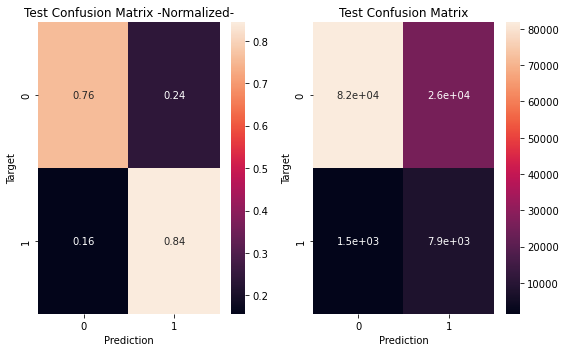

In [289]:
test_predictions = model.predict(X_test_tf[list(df_tf_ohe.columns) + columns_0].values)
plot_utils.predict_and_plot(np.rint(test_predictions), y_test, 'Test')
acc = accuracy_score(y_true=y_test, y_pred=np.rint(test_predictions))
rec = recall_score(y_true=y_test, y_pred=np.rint(test_predictions))
f1 = f1_score(y_true=y_test, y_pred=np.rint(test_predictions))

<ipython-input-291-4e8f5d65f66e>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


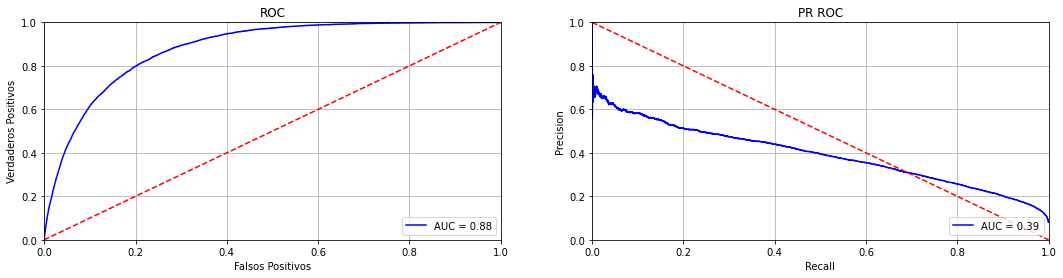

In [291]:
preds_NN_cw_0 = test_predictions

fpr, tpr, threshold = roc_curve(y_test, preds_NN_cw_0)
roc_auc_NN_cw_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_cw_0)
pr_roc_auc_NN_cw_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_cw_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_cw_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [292]:
results['modelNN_cw_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_cw_0, 'prc': pr_roc_auc_NN_cw_0}
results['modelNN_cw_0']

{'acc': 0.7661530050910582,
 'rec': 0.8435033070194154,
 'f1': 0.36614957166010653,
 'auc': 0.8811193807348859,
 'prc': 0.3918347170326347}

___

In [296]:
rb_scaler = RobustScaler().fit(X_train_tf[columns_1])
X_train_tf[columns_1] = rb_scaler.transform(X_train_tf[columns_1])
X_test_tf[columns_1] = rb_scaler.transform(X_test_tf[columns_1])

In [297]:
model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=METRICS
)

history = model.fit(
    X_train_tf[list(df_tf_ohe.columns) + columns_1].values, 
    y_train.values,
    epochs=20,
    batch_size=128,
    class_weight={0: weight_for_0, 1: weight_for_1},
)


Epoch 1/20
3659/3659 [==============================] - 7s 1ms/step - loss: 0.4735 - tp: 63386.0000 - fp: 214544.0000 - tn: 647010.0000 - fn: 11604.0000 - accuracy: 0.7585 - precision: 0.2281 - recall: 0.8453 - auc: 0.8738 - prc: 0.3669
Epoch 2/20
3659/3659 [==============================] - 6s 2ms/step - loss: 0.4347 - tp: 31848.0000 - fp: 106634.0000 - tn: 324143.0000 - fn: 5647.0000 - accuracy: 0.7602 - precision: 0.2300 - recall: 0.8494 - auc: 0.8788 - prc: 0.3715
Epoch 3/20
3659/3659 [==============================] - 5s 1ms/step - loss: 0.4281 - tp: 31882.0000 - fp: 105758.0000 - tn: 325019.0000 - fn: 5613.0000 - accuracy: 0.7622 - precision: 0.2316 - recall: 0.8503 - auc: 0.8804 - prc: 0.3740
Epoch 4/20
3659/3659 [==============================] - 5s 1ms/step - loss: 0.4248 - tp: 31840.0000 - fp: 104417.0000 - tn: 326360.0000 - fn: 5655.0000 - accuracy: 0.7649 - precision: 0.2337 - recall: 0.8492 - auc: 0.8816 - prc: 0.3805
Epoch 5/20
3659/3659 [==============================] -

Accuracy: 77.94%


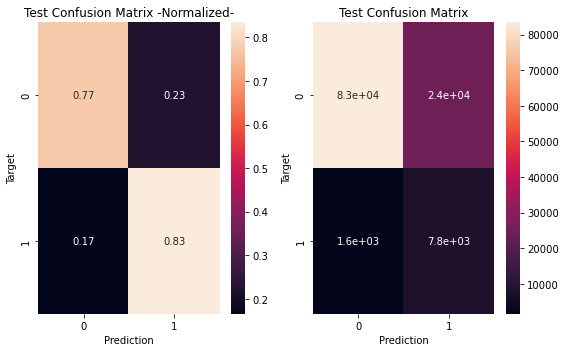

In [298]:
test_predictions = model.predict(X_test_tf[list(df_tf_ohe.columns) + columns_1].values)
plot_utils.predict_and_plot(np.rint(test_predictions), y_test, 'Test')
acc = accuracy_score(y_true=y_test, y_pred=np.rint(test_predictions))
rec = recall_score(y_true=y_test, y_pred=np.rint(test_predictions))
f1 = f1_score(y_true=y_test, y_pred=np.rint(test_predictions))

<ipython-input-299-54f986049c16>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


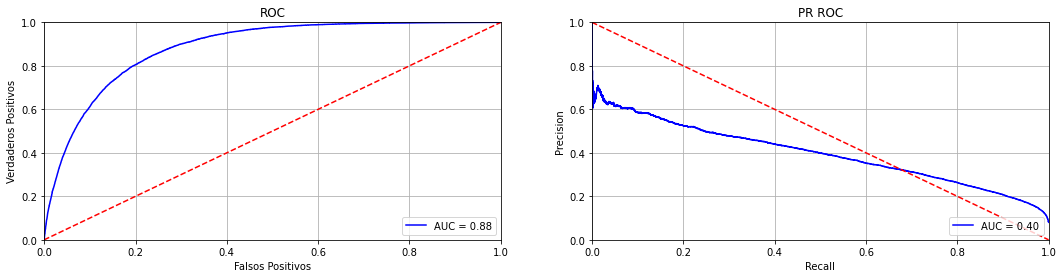

In [299]:
preds_NN_cw_1 = test_predictions

fpr, tpr, threshold = roc_curve(y_test, preds_NN_cw_1)
roc_auc_NN_cw_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_cw_1)
pr_roc_auc_NN_cw_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_cw_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_cw_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [300]:
results['modelNN_cw_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_cw_1, 'prc': pr_roc_auc_NN_cw_1}
results['modelNN_cw_1']

{'acc': 0.7793760891106024,
 'rec': 0.8343289950928099,
 'f1': 0.3771883289124668,
 'auc': 0.8841439282868997,
 'prc': 0.39689340133207446}

___

In [313]:
rb_scaler = RobustScaler().fit(X_train_tf[columns_2])
X_train_tf[columns_2] = rb_scaler.transform(X_train_tf[columns_2])
X_test_tf[columns_2] = rb_scaler.transform(X_test_tf[columns_2])

In [317]:
model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=METRICS
)

In [318]:
history = model.fit(
    X_train_tf[list(df_tf_ohe.columns) + columns_2].values, 
    y_train.values,
    epochs=20,
    batch_size=128,
    class_weight={0: weight_for_0, 1: weight_for_1},
)

Epoch 1/20
3659/3659 [==============================] - 7s 1ms/step - loss: 0.4483 - tp: 31494.0000 - fp: 107728.0000 - tn: 323049.0000 - fn: 6001.0000 - accuracy: 0.7571 - precision: 0.2262 - recall: 0.8400 - auc: 0.8705 - prc: 0.3526
Epoch 2/20
3659/3659 [==============================] - 5s 1ms/step - loss: 0.4301 - tp: 31818.0000 - fp: 105313.0000 - tn: 325464.0000 - fn: 5677.0000 - accuracy: 0.7630 - precision: 0.2320 - recall: 0.8486 - auc: 0.8789 - prc: 0.3710
Epoch 3/20
3659/3659 [==============================] - 5s 1ms/step - loss: 0.4265 - tp: 31825.0000 - fp: 104446.0000 - tn: 326331.0000 - fn: 5670.0000 - accuracy: 0.7648 - precision: 0.2335 - recall: 0.8488 - auc: 0.8808 - prc: 0.3774
Epoch 4/20
3659/3659 [==============================] - 5s 1ms/step - loss: 0.4247 - tp: 31922.0000 - fp: 104392.0000 - tn: 326385.0000 - fn: 5573.0000 - accuracy: 0.7652 - precision: 0.2342 - recall: 0.8514 - auc: 0.8816 - prc: 0.3795
Epoch 5/20
3659/3659 [==============================] - 

Accuracy: 74.75%


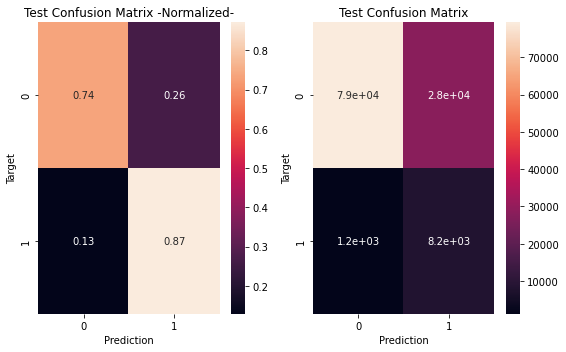

In [319]:
test_predictions = model.predict(X_test_tf[list(df_tf_ohe.columns) + columns_2].values)
plot_utils.predict_and_plot(np.rint(test_predictions), y_test, 'Test')
acc = accuracy_score(y_true=y_test, y_pred=np.rint(test_predictions))
rec = recall_score(y_true=y_test, y_pred=np.rint(test_predictions))
f1 = f1_score(y_true=y_test, y_pred=np.rint(test_predictions))

<ipython-input-320-fcf56ce6c462>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


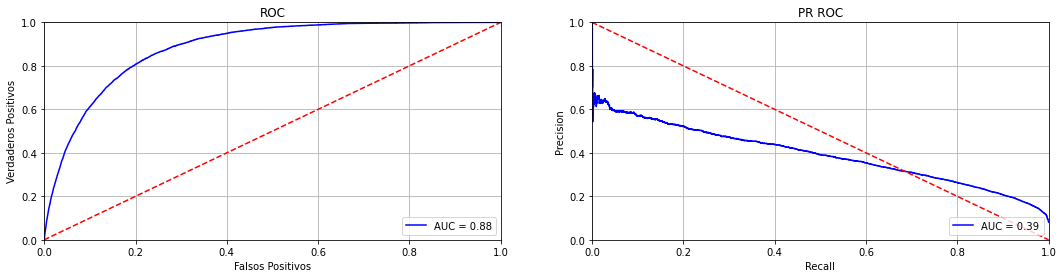

In [320]:
preds_NN_cw_2 = test_predictions

fpr, tpr, threshold = roc_curve(y_test, preds_NN_cw_2)
roc_auc_NN_cw_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_cw_2)
pr_roc_auc_NN_cw_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_cw_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_cw_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [321]:
results['modelNN_cw_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_cw_2, 'prc': pr_roc_auc_NN_cw_2}
results['modelNN_cw_2']

{'acc': 0.7474886390815594,
 'rec': 0.8712395988905484,
 'f1': 0.35589933543959035,
 'auc': 0.8833957243490018,
 'prc': 0.39129958061782943}

___

In [322]:
rb_scaler = RobustScaler().fit(X_train_tf[columns_reduced])
X_train_tf[columns_reduced] = rb_scaler.transform(X_train_tf[columns_reduced])
X_test_tf[columns_reduced] = rb_scaler.transform(X_test_tf[columns_reduced])

In [323]:
model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=METRICS
)

In [324]:
history = model.fit(
    X_train_tf[list(df_tf_ohe.columns) + columns_reduced].values, 
    y_train.values,
    epochs=20,
    batch_size=128,
    class_weight={0: weight_for_0, 1: weight_for_1},
)

Epoch 1/20
3659/3659 [==============================] - 7s 2ms/step - loss: 0.4492 - tp: 63813.0000 - fp: 214272.0000 - tn: 647282.0000 - fn: 11177.0000 - accuracy: 0.7593 - precision: 0.2295 - recall: 0.8510 - auc: 0.8784 - prc: 0.3727
Epoch 2/20
3659/3659 [==============================] - 5s 1ms/step - loss: 0.4332 - tp: 31682.0000 - fp: 104703.0000 - tn: 326074.0000 - fn: 5813.0000 - accuracy: 0.7640 - precision: 0.2323 - recall: 0.8450 - auc: 0.8782 - prc: 0.3722
Epoch 3/20
3659/3659 [==============================] - 5s 1ms/step - loss: 0.4286 - tp: 31806.0000 - fp: 104027.0000 - tn: 326750.0000 - fn: 5689.0000 - accuracy: 0.7657 - precision: 0.2342 - recall: 0.8483 - auc: 0.8799 - prc: 0.3765
Epoch 4/20
3659/3659 [==============================] - 5s 1ms/step - loss: 0.4252 - tp: 31949.0000 - fp: 104496.0000 - tn: 326281.0000 - fn: 5546.0000 - accuracy: 0.7650 - precision: 0.2342 - recall: 0.8521 - auc: 0.8815 - prc: 0.3822
Epoch 5/20
3659/3659 [==============================] -

Accuracy: 77.01%


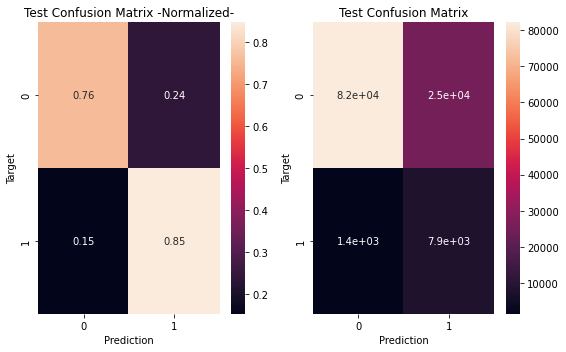

In [325]:
test_predictions = model.predict(X_test_tf[list(df_tf_ohe.columns) + columns_reduced].values)
plot_utils.predict_and_plot(np.rint(test_predictions), y_test, 'Test')
acc = accuracy_score(y_true=y_test, y_pred=np.rint(test_predictions))
rec = recall_score(y_true=y_test, y_pred=np.rint(test_predictions))
f1 = f1_score(y_true=y_test, y_pred=np.rint(test_predictions))

<ipython-input-326-497360a801a7>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


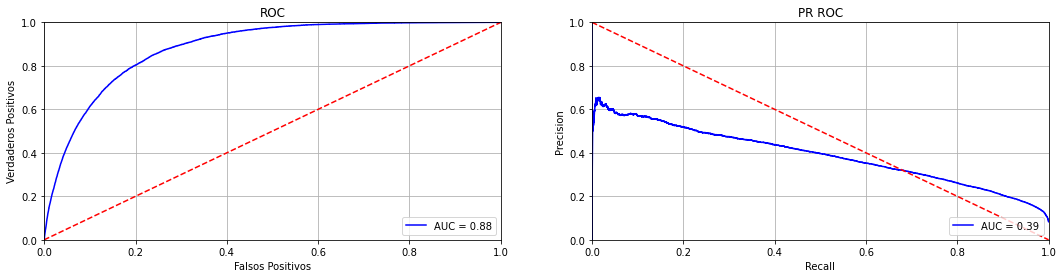

In [326]:
preds_NN_cw_3 = test_predictions

fpr, tpr, threshold = roc_curve(y_test, preds_NN_cw_3)
roc_auc_NN_cw_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_cw_3)
pr_roc_auc_NN_cw_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_cw_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_cw_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [327]:
results['modelNN_cw_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_cw_3, 'prc': pr_roc_auc_NN_cw_3}
results['modelNN_cw_3']

{'acc': 0.7700908873475245,
 'rec': 0.84798378493706,
 'f1': 0.3713358092168267,
 'auc': 0.8834597159216758,
 'prc': 0.3898015560083959}

___
## 7. Summary

In [330]:
print('Model results:')
pd.DataFrame.from_dict(results)

Model results:


,modelLR_0,modelLR_1,modelLR_2,modelLR_3,modelRF_0,modelRF_1,modelRF_2,modelRF_3,modelNN_0,modelNN_1,modelNN_2,modelNN_3,modelNN_cw_0,modelNN_cw_1,modelNN_cw_2,modelNN_cw_3
acc,0.920192,0.920841,0.920670,0.920713,0.913418,0.913367,0.912547,0.912794,0.921516,0.921516,0.919927,0.920200,0.766153,0.779376,0.747489,0.770091
rec,0.128547,0.131747,0.120119,0.127587,0.159697,0.160017,0.163217,0.161831,0.163324,0.163324,0.179859,0.149989,0.843503,0.834329,0.871240,0.847984
f1,0.205054,0.210446,0.195164,0.204900,0.228027,0.228276,0.230110,0.229102,0.249959,0.249959,0.264554,0.231364,0.366150,0.377188,0.355899,0.371336
auc,0.864212,0.859801,0.862326,0.863939,0.845195,0.845577,0.844009,0.843537,0.883158,0.884058,0.883831,0.883057,0.881119,0.884144,0.883396,0.883460
prc,0.356421,0.352467,0.354467,0.358919,0.305898,0.306668,0.303182,0.300291,0.430002,0.420380,0.418105,0.408669,0.391835,0.396893,0.391300,0.389802


Based on the f1 score, the best perfomances were achieved by the models using class weights. More techniques could be implemented to attack the imbalanced data problem (oversampling, SMOTE, etc).